In [1]:
# imports
import os, glob, pickle,random
import librosa
import librosa.display
import soundfile
import numpy as np  
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
#DataFlair - Emotions in the RAVDESS dataset
emotions={
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#DataFlair - Emotions to observe
observed_emotions=['happy','sad','angry','fearful','disgust','surprised']

In [3]:
#DataFlair - Extract features (mfcc, chroma, mel) from a sound file
SAMPLERATE = 16000 # Hz
def extract_feature(file_name):
    with soundfile.SoundFile(file_name) as sound_file:
        sample_rate=sound_file.samplerate
        X = sound_file.read(dtype="float32")
        if sample_rate != SAMPLERATE:
            X = librosa.resample(X, sample_rate, SAMPLERATE)
            sample_rate=SAMPLERATE 
        print('filename=', file_name, ' samplerate=', sample_rate)
        stft=np.abs(librosa.stft(X))
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=X, sr=sample_rate).T, axis=0)
        bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=X, sr=sample_rate).T, axis=0)
        flatness = np.mean(librosa.feature.spectral_flatness(y=X))
        contrast = np.mean(librosa.feature.spectral_contrast(y=X))
        result = np.hstack((mfccs, chroma, mel, tonnetz, bandwidth, flatness, contrast))
    return (X, result)

In [4]:
#DataFlair - Load the data and extract features for each sound file
cwd = os.getcwd()
def load_data(glob_pattern=cwd+"/dataset/Actor_*/*.wav"):
    X,x,y=[],[],[]
    for file in glob.glob(glob_pattern):
        file_name=os.path.basename(file)
        if file_name.split("-")[2] == '01' or file_name.split("-")[2] == '02':
            continue
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        Xo, feature=extract_feature(file)
        X.append(Xo)
        x.append(feature)
        y.append(emotion)
    return X,x,y

In [5]:
X,x,y = load_data()

0
filename= /Users/dorukhanarslan/git/ml2/dataset/Actor_09/03-01-06-02-01-02-09.wav  samplerate= 16000
filename= /Users/dorukhanarslan/git/ml2/dataset/Actor_09/03-01-05-02-01-01-09.wav  samplerate= 16000
filename= /Users/dorukhanarslan/git/ml2/dataset/Actor_09/03-01-05-01-02-01-09.wav  samplerate= 16000
filename= /Users/dorukhanarslan/git/ml2/dataset/Actor_09/03-01-06-01-02-02-09.wav  samplerate= 16000
filename= /Users/dorukhanarslan/git/ml2/dataset/Actor_09/03-01-03-01-01-02-09.wav  samplerate= 16000
filename= /Users/dorukhanarslan/git/ml2/dataset/Actor_09/03-01-03-02-02-02-09.wav  samplerate= 16000
filename= /Users/dorukhanarslan/git/ml2/dataset/Actor_07/03-01-03-02-02-02-07.wav  samplerate= 16000
filename= /Users/dorukhanarslan/git/ml2/dataset/Actor_07/03-01-03-01-01-02-07.wav  samplerate= 16000
filename= /Users/dorukhanarslan/git/ml2/dataset/Actor_07/03-01-08-02-02-01-07.wav  samplerate= 16000
filename= /Users/dorukhanarslan/git/ml2/dataset/Actor_07/03-01-08-01-01-01-07.wav  sample

In [6]:
def plot_emo_specs(x,y,emos,n):
    index = 1
    plt.figure()
    emo_data = dict()
    nemos = len(emos)
    fig = plt.figure(figsize=(n*7,nemos*5))
    for emo in observed_emotions:
        xys = [xyi for xyi in zip(x, y) if xyi[1] == emo]
        emo_data[emo] = random.sample(xys, n)
        for i, samp in enumerate(emo_data[emo]):
            ax = plt.subplot(nemos, n, index)
            ax.title.set_text(emo+' '+str(i+1))
            M = librosa.feature.melspectrogram(y=samp[0])
            librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                         y_axis='mel', x_axis='time')
            index += 1
    plt.show()

<Figure size 432x288 with 0 Axes>

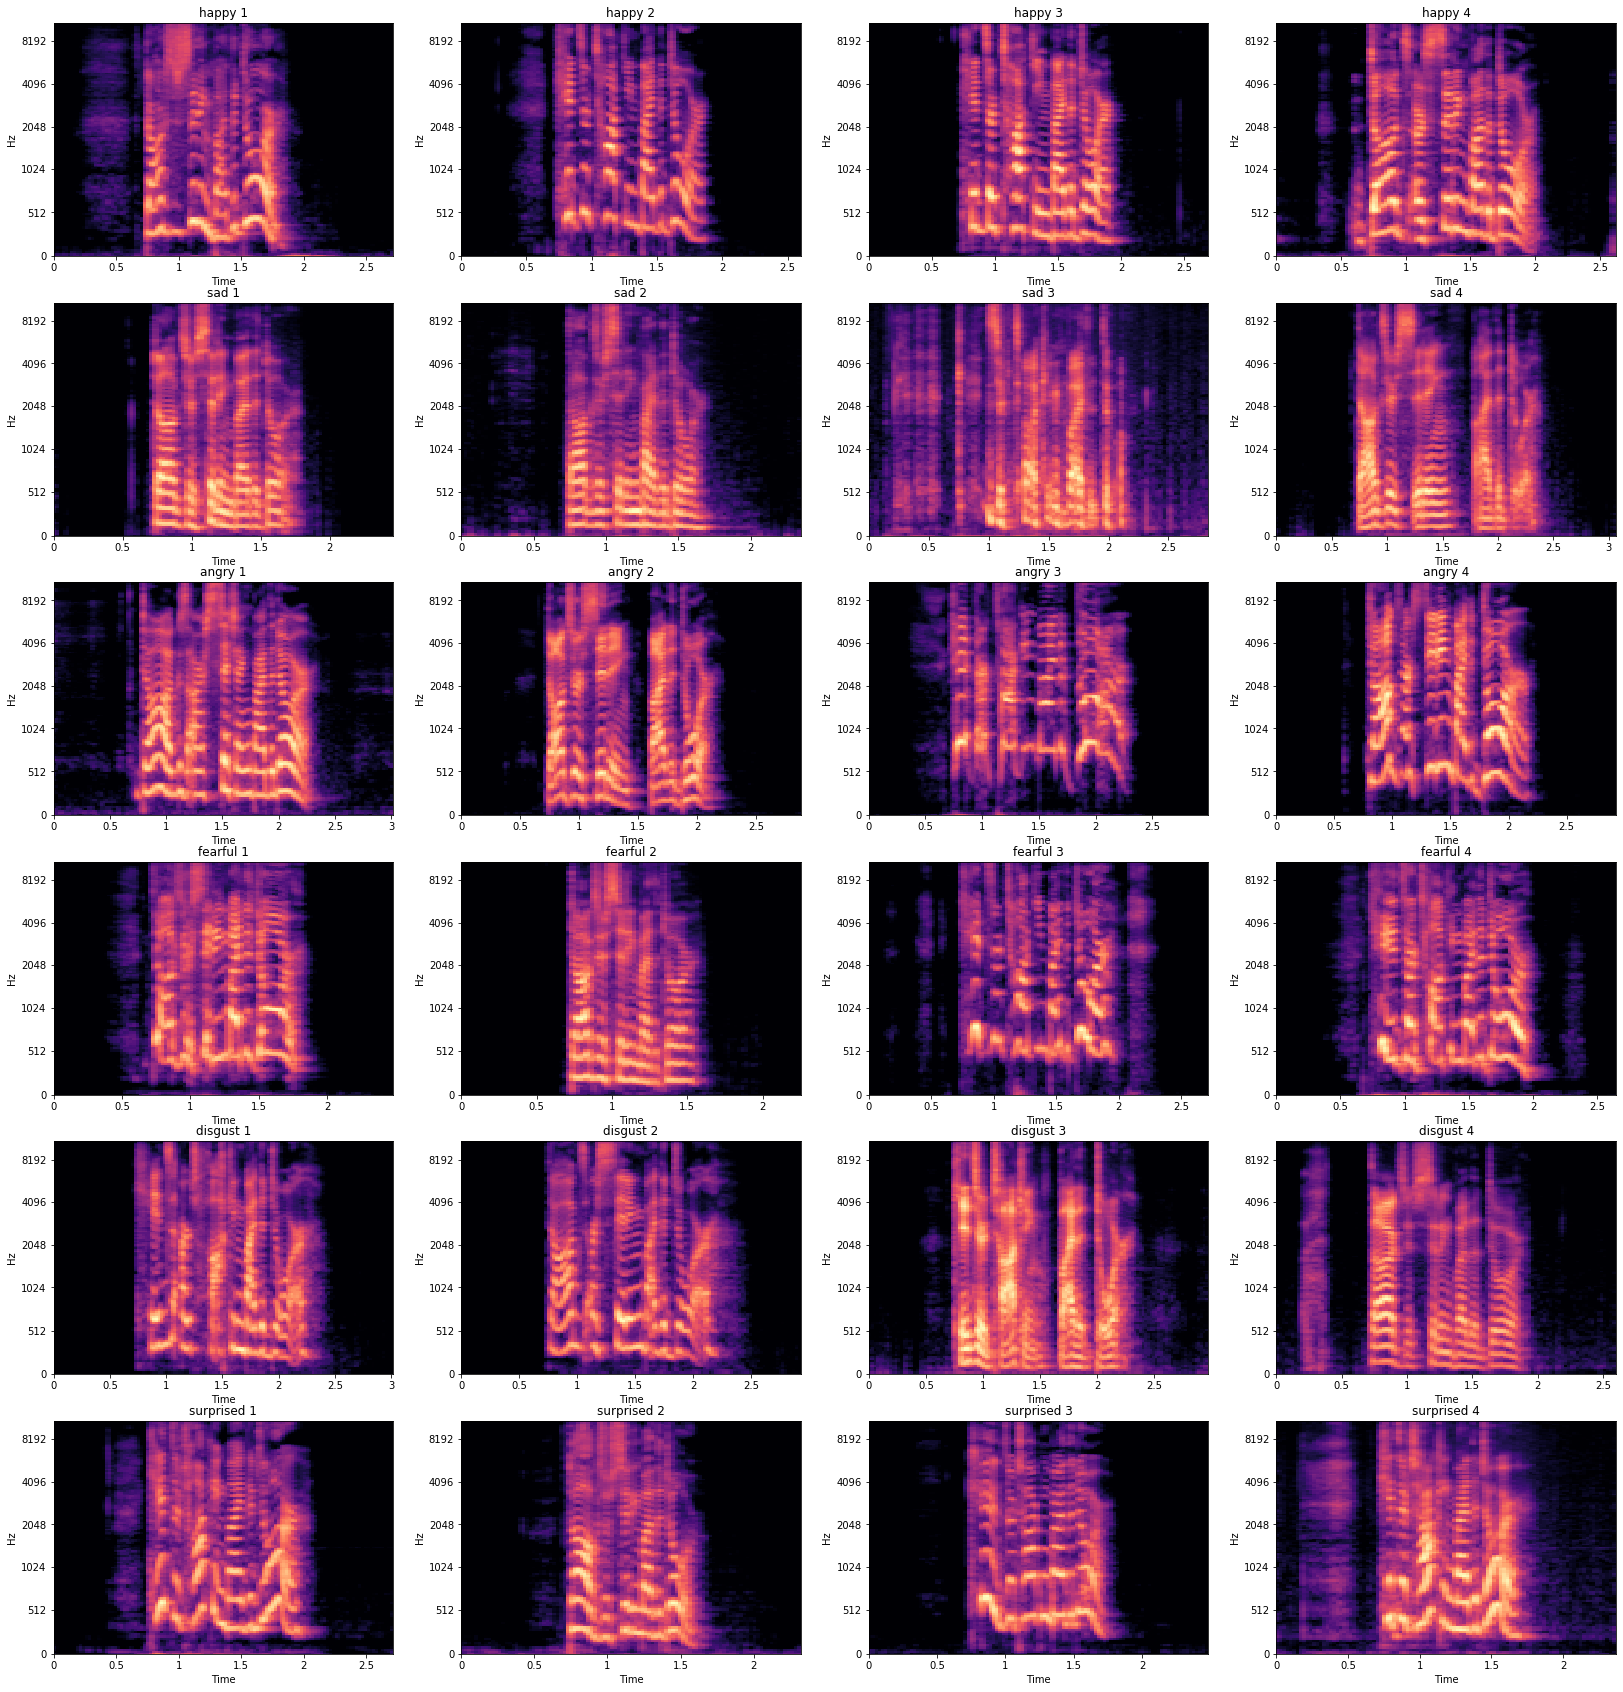

In [7]:
plot_emo_specs(X,y,observed_emotions, n=4)

In [8]:
#DataFlair - Split the dataset
x_train,x_test,y_train,y_test = train_test_split(np.array(x), y, test_size=0.2, random_state=9)

In [9]:
#DataFlair - Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

(921, 231)


In [11]:
#DataFlair - Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 189


# Improvements
- Ensemble classifier
- More features
    - librosa documentation
- Evolution of signal over time?

In [15]:
# Apply KNN Classifier using the same features
from sklearn import neighbors
from sklearn import svm
from sklearn import tree
from sklearn import naive_bayes
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [40]:
# Classifiers - MLP, K-Nearest Neighbor, Support Vector Machine and Decision Tree Classifier

mlp = MLPClassifier(alpha=0.01, batch_size=128, epsilon=1e-08, hidden_layer_sizes=(500,250,125,), learning_rate='adaptive', max_iter=2500)
# n=20 seems to be optimal
knn = neighbors.KNeighborsClassifier(20)
svm_clf = svm.SVC()
dtc = tree.DecisionTreeClassifier(max_depth=4)
nb = naive_bayes.GaussianNB()

# Newton-cg handles multinomial loss (for multiclass problems)
lr = linear_model.LogisticRegression(solver='newton-cg')

# Cross Validation using K-Fold
kf5 = KFold(n_splits=5, random_state=9)
skf5 = StratifiedKFold(n_splits=5, random_state=9)
kf10 = KFold(n_splits=10, random_state=9)
skf10 = StratifiedKFold(n_splits=10, random_state=9)

In [41]:
#Scores for different K-folds
from scipy import stats
import pprint
validators = [("5-fold", kf5), ("Stratified 5-fold",skf5), ("10-fold", kf10), ("Stratified 10-fold",skf10)]
for name, validator in validators:
    mlp_score = cross_val_score(mlp, x_train, y_train, cv=validator)
    knn_score = cross_val_score(knn, x_train, y_train, cv=validator)
    svm_score = cross_val_score(svm_clf, x_train, y_train, cv=validator)
    dtc_score = cross_val_score(dtc, x_train, y_train, cv=validator)
    nb_score = cross_val_score(nb, x_train, y_train, cv=validator)
    lr_score = cross_val_score(lr, x_train, y_train, cv=validator)

    # Scores of all folds per model
    print()
    print(name, "cross validation scores")
    print("MLP: ", stats.describe(mlp_score))
    print("K-NearestNeighbors: ", stats.describe(knn_score))
    print("SupportVectorMachine: ", stats.describe(svm_score))
    print("DecisionTreeClassifier: ", stats.describe(dtc_score))
    print("NaiveBayesGaussian: ", stats.describe(nb_score))
    print("LogisticRegression: ", stats.describe(lr_score))


5-fold cross validation scores
MLP:  DescribeResult(nobs=5, minmax=(0.20652173913043478, 0.41304347826086957), mean=0.32679788484136313, variance=0.005599203639597295, skewness=-0.7273382323775474, kurtosis=-0.3610435920918458)
K-NearestNeighbors:  DescribeResult(nobs=5, minmax=(0.266304347826087, 0.31521739130434784), mean=0.2866274970622797, variance=0.0004499645989165993, skewness=0.438780963942295, kurtosis=-1.5142629392928135)
SupportVectorMachine:  DescribeResult(nobs=5, minmax=(0.1358695652173913, 0.2864864864864865), mean=0.20403642773207992, variance=0.0039021286907916456, skewness=0.3036709745306376, kurtosis=-1.4560432219697468)
DecisionTreeClassifier:  DescribeResult(nobs=5, minmax=(0.32608695652173914, 0.4076086956521739), mean=0.3680669800235018, variance=0.0011020917362721116, skewness=-0.17070495814884562, kurtosis=-1.431382285872451)
NaiveBayesGaussian:  DescribeResult(nobs=5, minmax=(0.2756756756756757, 0.3532608695652174), mean=0.3214394829612221, variance=0.0008076

In [ ]:
import pickle
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)
with open('knn.pickle', 'wb') as f:
    pickle.dump(knn, f)

**10-fold**
```
K-NearestNeighbors Mean cross validation score:  0.37417218543046354
SupportVectorMachine Cross Val Score:  0.26026490066225166
DecisionTreeClassifier Cross Val Score:  0.4152317880794702
NaiveBayesGaussian Cross Val Score:  0.3125827814569536
LogisticRegression Cross Val Score:  0.6139072847682119
```

**Stratified 10-fold**
```
K-NearestNeighbors Mean cross validation score:  0.3655981666640524
SupportVectorMachine Cross Val Score:  0.2562045370969063
DecisionTreeClassifier Cross Val Score:  0.40846670593832834
NaiveBayesGaussian Cross Val Score:  0.31120110605498147
LogisticRegression Cross Val Score:  0.6112658790258537
```

**5-fold**
```
K-NearestNeighbors Mean cross validation score:  0.35562913907284766
SupportVectorMachine Cross Val Score:  0.2549668874172185
DecisionTreeClassifier Cross Val Score:  0.4145695364238411
NaiveBayesGaussian Cross Val Score:  0.31059602649006623
LogisticRegression Cross Val Score:  0.6079470198675497
```

Text(0.5, 1.0, 'MLP: Emotion detection confusion matrix')

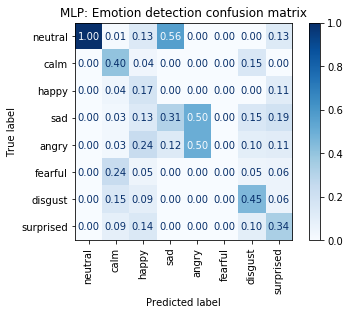

In [22]:
from sklearn.metrics import plot_confusion_matrix

# pax = plt.figure(figsize=(30,30))
fig = plot_confusion_matrix(mlp, x_test, y_test,
                      display_labels=observed_emotions,
                      cmap=plt.cm.Blues, xticks_rotation='vertical', normalize='pred', values_format='.2f')
fig.ax_.set_title("MLP: Emotion detection confusion matrix")